In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
df = pd.read_csv('/kaggle/input/a-quick-overview-of-clinical-trials/AERO-BirdsEye-Data.csv')
df.head()

,index,NCT,Sponsor,Title,Summary,Start_Year,Start_Month,Phase,Enrollment,Status,Condition
0,0,NCT00003305,Sanofi,A Phase II Trial of Aminopterin in Adults and ...,RATIONALE: Drugs used in chemotherapy use diff...,1997,7,Phase 2,75,Completed,Leukemia
1,1,NCT00003821,Sanofi,Phase II Trial of Aminopterin in Patients With...,RATIONALE: Drugs used in chemotherapy use diff...,1998,1,Phase 2,0,Withdrawn,Endometrial Neoplasms
2,2,NCT00004025,Sanofi,"Phase I/II Trial of the Safety, Immunogenicity...",RATIONALE: Vaccines made from a person's white...,1999,3,Phase 1/Phase 2,36,Unknown status,Melanoma
3,3,NCT00005645,Sanofi,Phase II Trial of ILX295501 Administered Orall...,RATIONALE: Drugs used in chemotherapy use diff...,1999,5,Phase 2,0,Withdrawn,Ovarian Neoplasms
4,4,NCT00008281,Sanofi,"A Multicenter, Open-Label, Randomized, Three-A...",RATIONALE: Drugs used in chemotherapy use diff...,2000,10,Phase 3,0,Unknown status,Colorectal Neoplasms


In [3]:
# top10 = pd.DataFrame(df.groupby('Condition').size().sort_values(ascending = True).tail(10))
# top10.columns = ['Total Trials']

# fig4 = px.bar(top10,
#               title = '<b> The 10 Most Studied Conditions<b>',
#               color_discrete_sequence = px.colors.qualitative.Pastel,
#               labels = {'value' : 'Total Trials'},
#               orientation = 'h',
#               height = 700,
#               width = 800)

# fig4.update_layout(title_x = .5, 
#                    title_y = .9, 
#                    font = dict(size = 14))
# fig4.update(layout_showlegend = False)

# fig4.show()

In [4]:
df.shape

(13748, 11)

In [5]:
df.dtypes

index           int64
NCT            object
Sponsor        object
Title          object
Summary        object
Start_Year      int64
Start_Month     int64
Phase          object
Enrollment      int64
Status         object
Condition      object
dtype: object

In [6]:
df['Status'].unique()

array(['Completed', 'Withdrawn', 'Unknown status', 'Terminated',
       'Recruiting', 'Active, not recruiting', 'Enrolling by invitation',
       'Not yet recruiting', 'Suspended'], dtype=object)

In [7]:
len(df[df['Status'] == 'Unknown status'])

19

In [8]:
df = df[df['Status'] != 'Unknown status']

In [9]:
# Values to replace
values_to_replace = ['Completed', 'Withdrawn', 'Terminated', 'Suspended']

# Replacement value
replacement_value = 0

# Replace values in the 'status' column
df['Status'] = df['Status'].replace(values_to_replace, replacement_value)

In [10]:
# Values to replace
values_to_replace = ['Recruiting', 'Active, not recruiting', 'Enrolling by invitation', 'Not yet recruiting']

# Replacement value
replacement_value = 1

# Replace values in the 'status' column
df['Status'] = df['Status'].replace(values_to_replace, replacement_value)

/tmp/ipykernel_24/90739017.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Status'] = df['Status'].replace(values_to_replace, replacement_value)


In [11]:
df.dtypes

index           int64
NCT            object
Sponsor        object
Title          object
Summary        object
Start_Year      int64
Start_Month     int64
Phase          object
Enrollment      int64
Status          int64
Condition      object
dtype: object

In [12]:
df.isnull().sum()

index            0
NCT              0
Sponsor          0
Title          144
Summary          0
Start_Year       0
Start_Month      0
Phase          261
Enrollment       0
Status           0
Condition        0
dtype: int64

In [13]:
df.dropna(inplace=True)

In [14]:
columns_to_keep = ['Phase', 'Sponsor', 'Status', 'Condition', 'Enrollment']
columns_to_drop = [col for col in df.columns if col not in columns_to_keep]

df.drop(columns=columns_to_drop, inplace=True) 
df.head()

,Sponsor,Phase,Enrollment,Status,Condition
0,Sanofi,Phase 2,75,0,Leukemia
1,Sanofi,Phase 2,0,0,Endometrial Neoplasms
3,Sanofi,Phase 2,0,0,Ovarian Neoplasms
6,Sanofi,Phase 3,0,0,Colorectal Neoplasms
7,Sanofi,Phase 3,0,0,"Carcinoma, Non-Small-Cell Lung"


In [15]:
order = ['Sponsor', 'Phase', 'Condition', 'Enrollment', 'Status']

df = df[order]
df.head()

,Sponsor,Phase,Condition,Enrollment,Status
0,Sanofi,Phase 2,Leukemia,75,0
1,Sanofi,Phase 2,Endometrial Neoplasms,0,0
3,Sanofi,Phase 2,Ovarian Neoplasms,0,0
6,Sanofi,Phase 3,Colorectal Neoplasms,0,0
7,Sanofi,Phase 3,"Carcinoma, Non-Small-Cell Lung",0,0


In [16]:
num_neg_match = len(df[df['Status'] == 0])
num_pos_match = len(df[df['Status'] == 1])

print(f"Negative matches: {num_neg_match}\nPositive matches: {num_pos_match}")

Negative matches: 11802
Positive matches: 1549


In [17]:
# Encode categorical variables
label_encoder = LabelEncoder()
df['Phase'] = label_encoder.fit_transform(df['Phase'])
df['Condition'] = label_encoder.fit_transform(df['Condition'])
df['Sponsor'] = label_encoder.fit_transform(df['Sponsor'])

In [18]:
import seaborn as sns

<Axes: xlabel='Status', ylabel='Enrollment'>

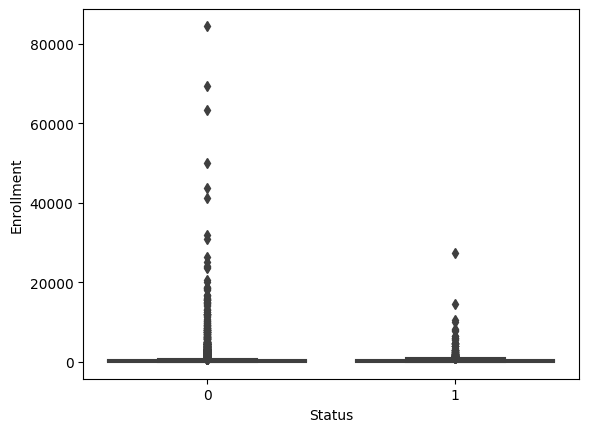

In [19]:
sns.boxplot(x="Status", y="Enrollment", data=df)

In [20]:
# calculate IQR for column epoch
Q1 = df['Enrollment'].quantile(0.25)
Q3 = df['Enrollment'].quantile(0.75)
IQR = Q3 - Q1

# identify outliers
threshold = 1.5
outliers = df[(df['Enrollment'] < Q1 - threshold * IQR) | (df['Enrollment'] > Q3 + threshold * IQR)]

df = df.drop(outliers.index)

In [21]:
# Feature Selection
features = ['Phase', 'Sponsor', 'Condition', 'Enrollment']
X = df[features]
y = df['Status']

In [22]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
X_test2 = X_test

In [24]:
X_test2.head()

,Phase,Sponsor,Condition,Enrollment
13385,3,8,119,305
253,6,9,657,30
12281,6,3,271,20
11396,3,4,515,50
3794,6,6,485,0


In [25]:
len(X_train), len(y_train), len(X_test), len(y_test)

(8523, 8523, 3654, 3654)

In [26]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Logistic Regression

In [27]:
model = LogisticRegression()
# model.fit(X_train, y_train)

In [28]:
rkf1 = RepeatedKFold(n_splits=8, n_repeats=4, random_state=42)

# Perform cross-validation
cv_scores1 = cross_val_score(model, X_train, y_train, cv=rkf1)

print("Cross-Validation Scores:", cv_scores1)

Cross-Validation Scores: [0.87804878 0.88836773 0.88086304 0.89483568 0.89765258 0.89483568
 0.87511737 0.89483568 0.88086304 0.86116323 0.89493433 0.87887324
 0.90140845 0.91173709 0.8741784  0.90140845 0.88273921 0.88461538
 0.9043152  0.87981221 0.88262911 0.87511737 0.90140845 0.89389671
 0.89118199 0.88086304 0.89118199 0.88826291 0.90422535 0.87793427
 0.87887324 0.89201878]


In [29]:
mean_accuracy1 = cv_scores1.mean()
print("Mean Accuracy for dataset1:", mean_accuracy1)

Mean Accuracy for dataset1: 0.888068687295757


In [30]:
model.fit(X_train, y_train)

LogisticRegression()

In [31]:
# Predictions
y_pred = model.predict(X_test)

In [32]:
# Assuming y_test is the true labels and y_pred are the predicted labels from your model
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')

In [33]:
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall (Sensitivity): {recall}")

F1 Score: 0.8306972617392548
Precision: 0.7828423702241719
Recall (Sensitivity): 0.884783798576902


# Decision Tree 

In [34]:
dtree_model = DecisionTreeClassifier()

In [35]:
# rkf1 = RepeatedKFold(n_splits=10, n_repeats=4, random_state=42)

# # Perform cross-validation
# cv_scores1 = cross_val_score(dtree_model, X_train, y_train, cv=rkf1)

# print("Cross-Validation Scores:", cv_scores1)

In [36]:
# mean_accuracy1 = cv_scores1.mean()
# print("Mean Accuracy for dataset1:", mean_accuracy1)

In [37]:
# Number of base models (iterations)
n_estimators = 12
 
# Create the Bagging classifier
bagging_classifier = BaggingClassifier(estimator=dtree_model, n_estimators=n_estimators)
 
# Train the Bagging classifier
bagging_classifier.fit(X_train, y_train)
 
# Make predictions on the test set
y_pred = bagging_classifier.predict(X_test)
 
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8812260536398467


In [38]:
dtree_model.fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 

In [39]:
# Assuming y_test is the true labels and y_pred are the predicted labels from your model
f1 = f1_score(y_test, dtree_predictions, average='weighted')
precision = precision_score(y_test, dtree_predictions, average='weighted', zero_division=0)
recall = recall_score(y_test, dtree_predictions, average='weighted')

In [40]:
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall (Sensitivity): {recall}")

F1 Score: 0.8447634857229518
Precision: 0.845818321363786
Recall (Sensitivity): 0.8437328954570333


# Support Vector Machine

In [41]:
svm_model_linear = SVC(kernel = 'linear', C = 1)

In [42]:
rkf1 = RepeatedKFold(n_splits=10, n_repeats=4, random_state=42)

# Perform cross-validation
cv_scores1 = cross_val_score(svm_model_linear, X_train, y_train, cv=rkf1)

print("Cross-Validation Scores:", cv_scores1)

Cross-Validation Scores: [0.86518171 0.89917937 0.89097304 0.87206573 0.90023474 0.90258216
 0.88849765 0.89319249 0.87676056 0.89201878 0.88042204 0.87338804
 0.86987104 0.88732394 0.88380282 0.89788732 0.90962441 0.87206573
 0.90258216 0.90375587 0.87807737 0.89214537 0.89214537 0.89319249
 0.88380282 0.8685446  0.88849765 0.88262911 0.91666667 0.88497653
 0.8862837  0.88393904 0.89800703 0.88380282 0.88732394 0.91079812
 0.8814554  0.87676056 0.87910798 0.89319249]


In [43]:
mean_accuracy1 = cv_scores1.mean()
print("Mean Accuracy for dataset1:", mean_accuracy1)

Mean Accuracy for dataset1: 0.8880689667508765


In [44]:
# svm_model_linear.fit(X_train, y_train) 
# svm_predictions = svm_model_linear.predict(X_test)

In [45]:
# # Assuming y_test is the true labels and y_pred are the predicted labels from your model
# f1 = f1_score(y_test, svm_predictions, average='weighted')
# precision = precision_score(y_test, svm_predictions, average='weighted', zero_division=0)
# recall = recall_score(y_test, svm_predictions, average='weighted')

In [46]:
# print(f1), print(precision), print(recall)

# K-Nearest Neighbour

In [47]:
# training a KNN classifier 
knn = KNeighborsClassifier(n_neighbors = 10)

In [48]:
rkf1 = RepeatedKFold(n_splits=8, n_repeats=4, random_state=42)

# Perform cross-validation
cv_scores1 = cross_val_score(knn, X_train, y_train, cv=rkf1)

print("Cross-Validation Scores:", cv_scores1)

Cross-Validation Scores: [0.87804878 0.88742964 0.87711069 0.90046948 0.89859155 0.89295775
 0.87981221 0.89859155 0.87898687 0.86585366 0.89868668 0.87887324
 0.90140845 0.90985915 0.87230047 0.90234742 0.88273921 0.88649156
 0.90337711 0.88450704 0.88638498 0.87699531 0.89765258 0.89201878
 0.89305816 0.8836773  0.88649156 0.89014085 0.90516432 0.87699531
 0.88169014 0.89577465]


In [49]:
mean_accuracy1 = cv_scores1.mean()
print("Mean Accuracy for dataset1:", mean_accuracy1)

Mean Accuracy for dataset1: 0.8888902009618688


In [50]:
knn.fit(X_train, y_train) 
preds = knn.predict(X_test)

In [51]:
# Assuming y_test is the true labels and y_pred are the predicted labels from your model
f1 = f1_score(y_test, preds, average='weighted')
precision = precision_score(y_test, preds, average='weighted', zero_division=0)
recall = recall_score(y_test, preds, average='weighted')

In [52]:
print(f1), print(precision), print(recall)

0.8370420620159863
0.840729236477599
0.8845101258894362


(None, None, None)

# Logistic Regression with GridSearchCV

**Alt NB**

In [53]:
C_vals = [1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,16.5,17]
penalties = ['l2']

param = {'penalty': penalties, 'C': C_vals}

## Calling on GridSearchCV object. 
grid_log = GridSearchCV(estimator=LogisticRegression(), 
                           param_grid = param,
                           scoring = 'accuracy',
                           cv = 5
                          )
## Fitting the model
grid_log.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15,
                               16, 16.5, 17],
                         'penalty': ['l2']},
             scoring='accuracy')

In [54]:
### Using the best parameters from the grid-search.
logreg_grid = grid_log.best_estimator_

log_train_grid = round(logreg_grid.score(X_train, y_train) * 100, 2)
log_accuracy_grid = logreg_grid.score(X_train,y_train).round(2)*100

print("Training Accuracy with GridSearch :",log_train_grid  ,"%")
print("Model Accuracy with GridSearch    :",log_accuracy_grid ,"%")

Training Accuracy with GridSearch : 88.81 %
Model Accuracy with GridSearch    : 89.0 %


In [55]:
preds = logreg_grid.predict(X_test)

In [56]:
# Assuming y_test is the true labels and y_pred are the predicted labels from your model
f1 = f1_score(y_test, preds, average='weighted')
precision = precision_score(y_test, preds, average='weighted', zero_division=0)
recall = recall_score(y_test, preds, average='weighted')

In [57]:
print(f1), print(precision), print(recall)

0.8306972617392548
0.7828423702241719
0.884783798576902


(None, None, None)

# Gradient Boosting

In [58]:
from sklearn.ensemble import GradientBoostingClassifier

In [59]:
gbc = GradientBoostingClassifier(n_estimators=300,
                                 learning_rate=0.05,
                                 random_state=100,
                                 max_features=5 )
# Fit to training set
gbc.fit(X_train, y_train)
 
# Predict on test set
pred_y = gbc.predict(X_test)
 
# accuracy
acc = accuracy_score(y_test, pred_y)
print("Gradient Boosting Classifier accuracy is : ", acc)

Gradient Boosting Classifier accuracy is :  0.8894362342638205


In [60]:
predictions_df = pd.DataFrame(df[:3654], columns=features)

# Add a column for the actual values
predictions_df['Actual'] = y_test

# Add a column for the predicted values
predictions_df['Predicted'] = pred_y

# Display the DataFrame to see predictions for each condition
print(predictions_df)

      Phase  Sponsor  Condition  Enrollment  Actual  Predicted
0         3        9        438          75     0.0          0
1         3        9        246           0     NaN          0
3         3        9        591           0     NaN          0
6         5        9        163           0     0.0          0
7         5        9        117           0     NaN          0
...     ...      ...        ...         ...     ...        ...
4139      6        6        361          44     0.0          0
4140      5        6        211          94     0.0          0
4141      1        6        543          12     0.0          0
4142      5        6        144          95     0.0          0
4143      5        6        293         248     NaN          0

[3654 rows x 6 columns]


In [61]:
predictions_df.dropna(inplace=True)

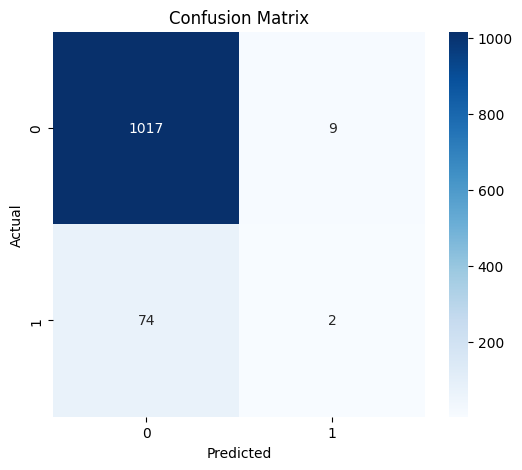

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
conf_matrix = confusion_matrix(predictions_df['Actual'], predictions_df['Predicted'])

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['Status'].unique(), yticklabels=df['Status'].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [63]:
rkf1 = RepeatedKFold(n_splits=8, n_repeats=4, random_state=42)

# Perform cross-validation
cv_scores1 = cross_val_score(gbc, X_train, y_train, cv=rkf1)

print("Cross-Validation Scores:", cv_scores1)

Cross-Validation Scores: [0.89774859 0.88742964 0.88273921 0.90234742 0.90328638 0.90422535
 0.88544601 0.90046948 0.88930582 0.87992495 0.90337711 0.88826291
 0.90985915 0.90892019 0.88075117 0.90985915 0.89399625 0.89305816
 0.9108818  0.88356808 0.89859155 0.88638498 0.90516432 0.89295775
 0.88930582 0.89493433 0.89399625 0.89953052 0.91549296 0.88638498
 0.89107981 0.90140845]


In [64]:
mean_accuracy1 = cv_scores1.mean()
print("Mean Accuracy for dataset1:", mean_accuracy1)

Mean Accuracy for dataset1: 0.8959590170793366


In [65]:
# Assuming y_test is the true labels and y_pred are the predicted labels from your model
f1 = f1_score(y_test, pred_y, average='weighted')
precision = precision_score(y_test, pred_y, average='weighted', zero_division=0)
recall = recall_score(y_test, pred_y, average='weighted')

In [66]:
print(f1), print(precision), print(recall)

0.8510624014299225
0.864378313331801
0.8894362342638205


(None, None, None)